# Convolutional autoencoder for image denoising
[See Supplementary Table 3~5 for Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.models import Model
from keras.callbacks import LearningRateScheduler


# def preprocess(array):
#     """Normalizes the supplied array and reshapes it."""
#     array = array.astype("float32") / 255.0
#     array = np.reshape(array, (len(array), 800, 1))
#     return array


def noise(array, noise_factor = 0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2, n = 4):
    """Displays <n> random signals from each array."""
    indices = np.random.randint(len(array1), size=n)
    signals1 = array1[indices, :]
    signals2 = array2[indices, :]

    plt.figure(figsize=(20, n))
    for i, (signal1, signal2) in enumerate(zip(signals1, signals2)):
        # Original signal
        ax = plt.subplot(2, n, i + 1)
        plt.plot(signal1)
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Noisy signal
        ax = plt.subplot(2, n, i + 1 + n)
        plt.plot(signal2)
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def check_nan(data):
    """Check whether there are samples with NaN in data."""
    with_nan = 0
    nan_index = []
    for i in range(len(data)):
        if np.any(np.isnan(data[i])):  # Check whethere there are data with NaN
            with_nan += 1
            nan_index.append(i)
    return with_nan, nan_index


## Prepare the data

Obtain the data from [https://www.synapse.org/Synapse:syn21985690](https://www.synapse.org/Synapse:syn21985690)
You will need to sign in with an account to access it.

In [2]:
# Path to .npz files
train_npz_path = "../data/train.npz"
test_npz_path = "../data/test.npz"
validate_npz_path = "../data/validate.npz"

# Load data
train_npz = np.load(train_npz_path)
test_npz = np.load(test_npz_path)
validate_npz = np.load(validate_npz_path)

# Signals
train_data = train_npz["signal"]
test_data = test_npz["signal"]
validate_data = validate_npz["signal"]

# Rhythm labels
train_labels_rhythm = train_npz["rhythm"]
test_labels_rhythm = train_npz["rhythm"]
validate_labels_rhythm = train_npz["rhythm"]

# Quality Assessment labels
train_labels_qa = train_npz["qa_label"]
test_labels_qa = train_npz["qa_label"]
validate_labels_qa = train_npz["qa_label"]

print(train_data.shape)
print(test_data.shape)
print(validate_data.shape)

(2803934, 800, 1)
(17617, 800, 1)
(518782, 800, 1)


For demonstration purpose only, we will only be using a subset of the dataset

In [3]:
train_size = 10000
test_size = 500
validate_size = 600

# Randomly choose samples
train_indices = np.random.choice(train_data.shape[0], size=train_size, replace=False)
test_indices = np.random.choice(test_data.shape[0], size=test_size, replace=False)
validate_indices = np.random.choice(validate_data.shape[0], size=validate_size, replace=False)

# Train, Test, Validate (Subsets)
train_data = train_data[train_indices]
test_data = test_data[test_indices]
validate_data = validate_data[validate_indices]

# Labels
train_labels_rhythm = train_labels_rhythm[train_indices]
test_labels_rhythm = test_labels_rhythm[test_indices]
validate_labels_rhythm = validate_labels_rhythm[validate_indices]

train_labels_qa = train_labels_qa[train_indices]
test_labels_qa = test_labels_qa[test_indices]
validate_labels_qa = validate_labels_qa[validate_indices]

print("Train data subset shape:", train_data.shape)
print("Test data subset shape:", test_data.shape)
print("Validate data subset shape:", validate_data.shape)

Train data subset shape: (10000, 800, 1)
Test data subset shape: (500, 800, 1)
Validate data subset shape: (600, 800, 1)


## Remove NaN samples

In [4]:
print(check_nan(train_data))
print(check_nan(test_data))
print(check_nan(validate_data))


(14, [2308, 2492, 2542, 3867, 3976, 4197, 4416, 4668, 4874, 5257, 5691, 5703, 7479, 7497])
(0, [])
(0, [])


In [5]:
# Ensure we check for NaNs across all dimensions except the first
valid_train_mask = ~np.isnan(train_data).any(axis=tuple(range(1, train_data.ndim)))
valid_test_mask = ~np.isnan(test_data).any(axis=tuple(range(1, test_data.ndim)))
valid_validate_mask = ~np.isnan(validate_data).any(axis=tuple(range(1, validate_data.ndim)))

# Apply the mask to remove rows with NaNs
train_data = train_data[valid_train_mask]
test_data = test_data[valid_test_mask]
validate_data = validate_data[valid_validate_mask]

train_labels_rhythm = train_labels_rhythm[valid_train_mask]
test_labels_rhythm = test_labels_rhythm[valid_test_mask]
validate_labels_rhythm = validate_labels_rhythm[valid_validate_mask]

train_labels_qa = train_labels_qa[valid_train_mask]
test_labels_qa = test_labels_qa[valid_test_mask]
validate_labels_qa = validate_labels_qa[valid_validate_mask]

print("Train data subset shape after removing NaN:", train_data.shape)
print("Test data subset shape after removing NaN:", test_data.shape)
print("Validate data subset shape after removing NaN:", validate_data.shape)

Train data subset shape after removing NaN: (9986, 800, 1)
Test data subset shape after removing NaN: (500, 800, 1)
Validate data subset shape after removing NaN: (600, 800, 1)


Noise Factor: 0.001


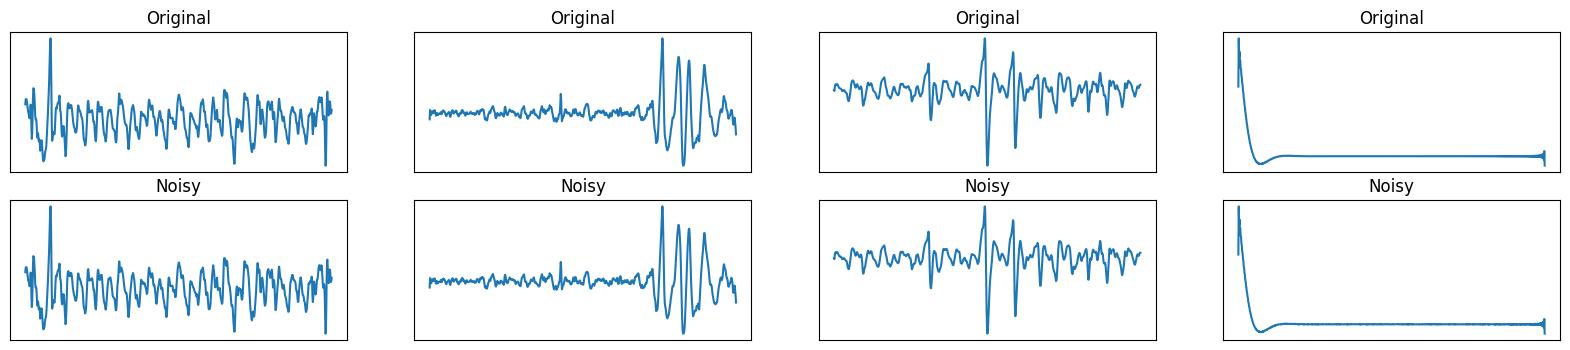

Noise Factor: 0.25


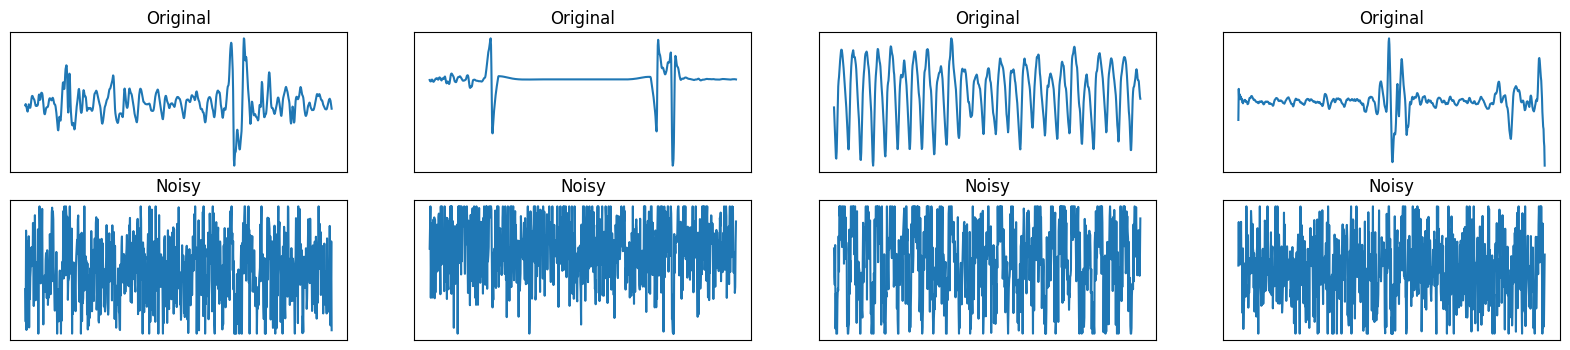

Noise Factor: 0.5


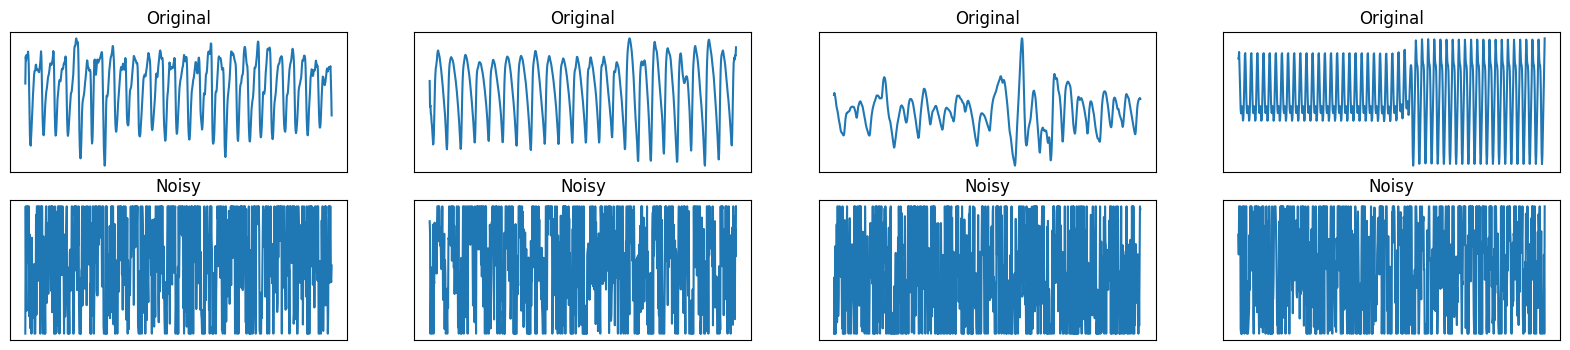

Noise Factor: 0.75


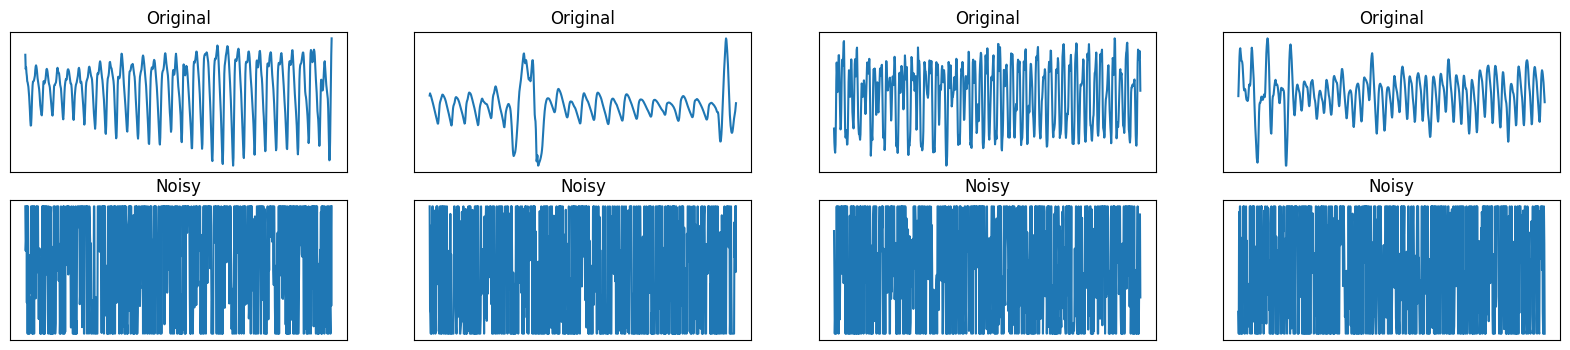

Noise Factor: 1


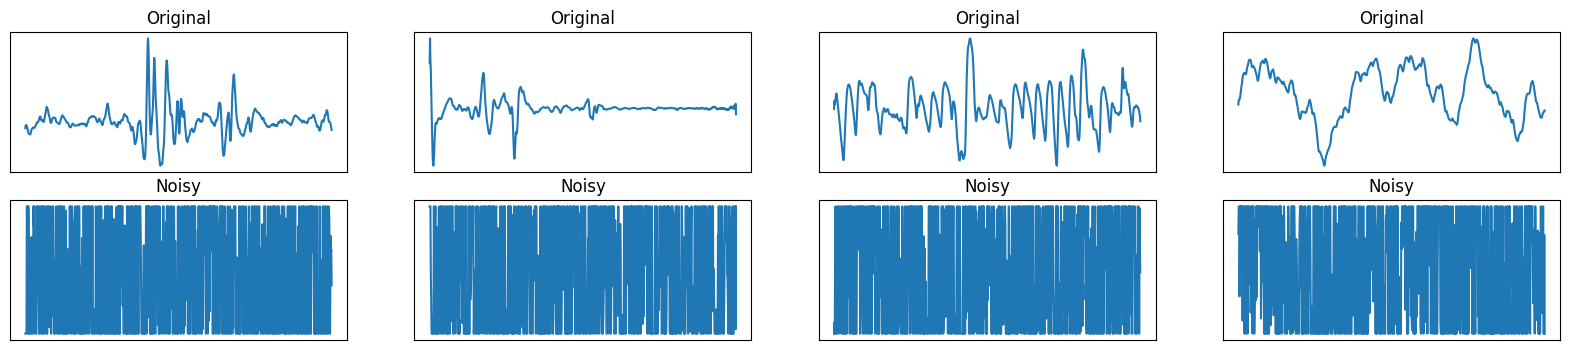

Noise Factor: 2


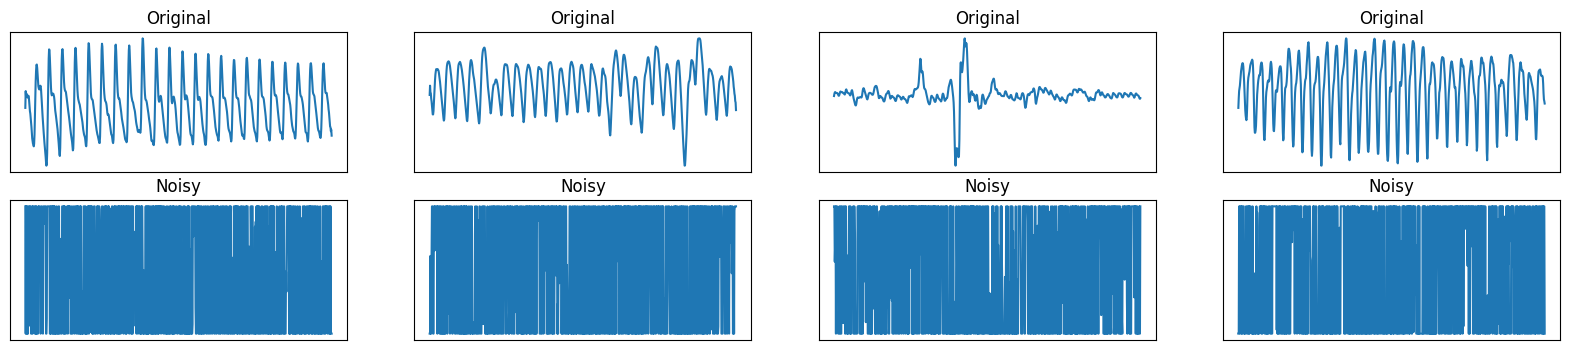

Noise Factor: 5


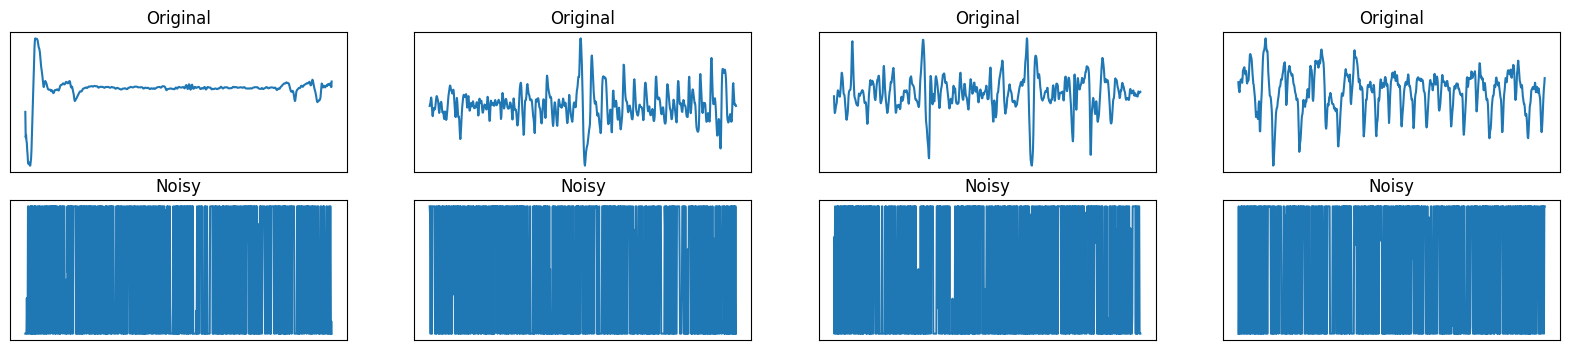

In [6]:
# Create a copy of the data with added noise
noise_levels = [0.001, 0.25, 0.5, 0.75, 1, 2, 5]
noisy_train_data = []
noisy_test_data = []
noisy_validate_data = []
for noise_factor in noise_levels:
    noisy_train_data.append(noise(train_data, noise_factor = noise_factor))
    noisy_test_data.append(noise(test_data, noise_factor = noise_factor))
    noisy_validate_data.append(noise(validate_data, noise_factor = noise_factor))

# Display the train data with added noise
for i in range(len(noise_levels)):
    print(f"Noise Factor: {noise_levels[i]}")
    display(train_data, noisy_train_data[i])

# Comcatenate all noisy images to become a whole dataset
simulated_noisy_train_data = np.concatenate(noisy_train_data, axis=0)
simulated_noisy_test_data = np.concatenate(noisy_test_data, axis=0)
simulated_noisy_validate_data = np.concatenate(noisy_validate_data, axis=0)

In [7]:
# Make sure there's no NaN samples
print(check_nan(simulated_noisy_train_data))
print(check_nan(simulated_noisy_test_data))
print(check_nan(simulated_noisy_validate_data))

(0, [])
(0, [])
(0, [])


## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

[See Supplementary Table 3 for CDAE Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

In [8]:
from keras.initializers import he_normal

# Input Layer
input_layer = layers.Input(shape=(800, 1)) 

# Encoder
x = layers.Conv1D(filters=64, kernel_size=10, activation='relu', padding='same', kernel_initializer=he_normal())(input_layer)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=45, kernel_size=8, activation='relu', padding='same', kernel_initializer=he_normal())(x)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=50, kernel_size=5, activation='relu', padding='same', kernel_initializer=he_normal())(x)
cdae_encoder = layers.MaxPooling1D(pool_size=2)(x) 

# Decoder
x = layers.Conv1D(filters=50, kernel_size=5, activation='relu', padding='same', kernel_initializer=he_normal())(cdae_encoder)
x = layers.UpSampling1D(size=2)(x) 
x = layers.Conv1D(filters=45, kernel_size=8, activation='relu', padding='same', kernel_initializer=he_normal())(x)
x = layers.UpSampling1D(size=3)(x)  
x = layers.Conv1D(filters=64, kernel_size=10, activation='relu', padding='same', kernel_initializer=he_normal())(x)
x = layers.UpSampling1D(size=3)(x)  

# Flatten
x = layers.Flatten()(x)  # (None, 792, 64) -> (None, 792 * 64) = (None, 50688)

# Dense
x = layers.Dense(units=800, activation='relu', kernel_initializer=he_normal())(x)  # (None, 50688) -> (None, 800)

# Reshape to match input shape
x = layers.Reshape((800, 1))(x)  # (None, 800) -> (None, 800, 1)

# Build CDAE model
cdae = Model(inputs=input_layer, outputs=x)
cdae.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
cdae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 800, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 266, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 266, 45)        │        23,085 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 88, 45)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 88, 50)         │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 44, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 50)         │        12,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 88, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 88, 45)         │        18,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 264, 45)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 264, 64)        │        28,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 792, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │    40,551,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 800, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,645,748 (155.05 MB)

 Trainable params: 40,645,748 (155.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train CDAE

Now we can train our autoencoder using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images. Notice we are setting up the validation data using the same
format.

In [9]:
print("simulated_noisy_train_data shape:", simulated_noisy_train_data.shape)
print("train_data shape before tiling:", train_data.shape)
print("y shape after tiling:", np.tile(train_data, (len(noise_levels), 1, 1)).shape)

simulated_noisy_train_data shape: (69902, 800, 1)
train_data shape before tiling: (9986, 800, 1)
y shape after tiling: (69902, 800, 1)


In [10]:
# Initial learning rate
initial_lr = 0.01

def lr_schedule(epoch, lr):
    if epoch % 25 == 0 and epoch > 0:
        return max(lr - 0.001, 0.0001)  # Make sure the learning rate does not become negative
    return lr

lr_reduction = LearningRateScheduler(lr_schedule, verbose=1)

# Train Autoencoder
history = cdae.fit(
    # The input to the CDAE was the simulated signal dataset
    # with a Gaussian noise factor of 0.001, 0.5, 0.25, 0.75,
    # 1, 2, and 5 added to corrupt the simulated signals.
    x=simulated_noisy_train_data,

    # The uncorrupted simulated signals are then used as the
    # target for reconstruction.
    y=np.tile(train_data, (len(noise_levels), 1, 1)),
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(simulated_noisy_validate_data, np.tile(validate_data, (len(noise_levels), 1, 1))),
    callbacks=[lr_reduction]
)

print(history.history) 


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 68s 122ms/step - loss: 0.2776 - val_loss: 0.0662 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 69s 127ms/step - loss: 0.0619 - val_loss: 0.0582 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 69s 127ms/step - loss: 0.0560 - val_loss: 0.0566 - learning_rate: 0.0010
{'loss': [0.1089518666267395, 0.05967298150062561, 0.05543317273259163], 'val_loss': [0.06624089926481247, 0.05824284255504608, 0.056595318019390106], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}


## Use CDAE for prediction

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

Since now I'm only using a very tiny subset of the dataset, it makes sense that the model is performing very badly.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


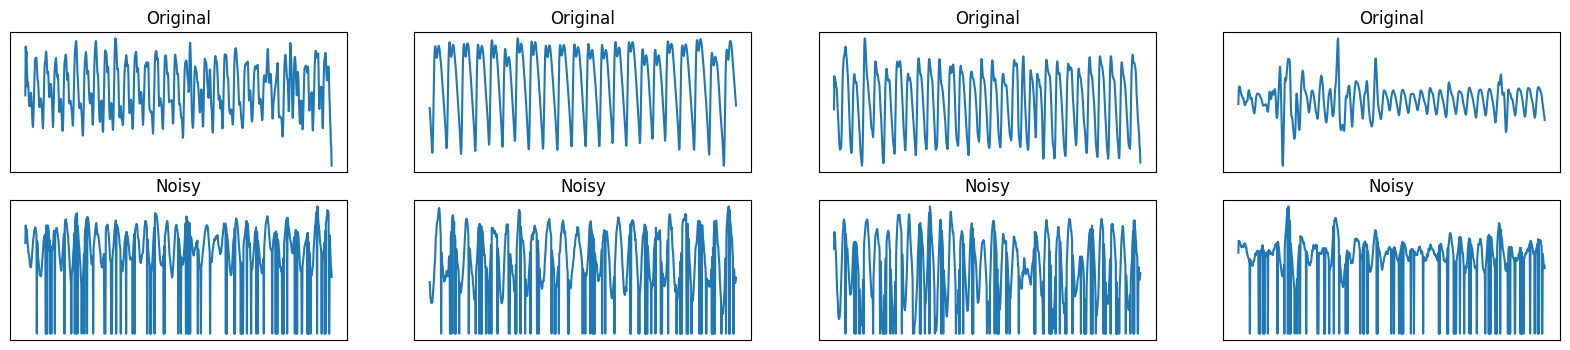

In [11]:
predictions = cdae.predict(test_data)
display(test_data, predictions)

# Transfer Learning

[See here for tutorial](https://keras.io/guides/transfer_learning/)

The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights (from pre-trained CDAE as illustrated above) into it.
2. Freeze all layers in the base model by setting <code>trainable = False</code>.
3. Create a new model (DeepBeat Architecture) on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

## Obtain pre-trained CDAE encoder weights

In [12]:
cdae_encoder_weights = cdae.get_weights()[:6]

# DeepBeat Architecture (Multi-Task Learning)
TODO: Modify the code based on the workflow.

[See Supplementary Table 5 for Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

## Shared Layers

In [13]:
# Input Layer
input_layer = layers.Input(shape=(800, 1)) 

# 1. Encoder (Base Model).
# Use pre-trained CDAE encoder weights here
x = layers.Conv1D(filters=64, kernel_size = 10, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=45, kernel_size = 8, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=50, kernel_size=5, activation='relu', padding='same')(x)
base_model = layers.MaxPooling1D(pool_size=2)(x) 

# 2. Define model
encoder_model = Model(inputs=input_layer, outputs=base_model, name="encoder_model")

# 3. Load pre-trained encoder weights
encoder_model.set_weights(cdae_encoder_weights)

# 4. Freeze encoder layers
encoder_model.trainable = False  

# 5. Build base model
base_model = encoder_model(input_layer)

# 3. Create new model on top of base model
# DeepBeat Architecture:
# Shared Layers
shared_input = layers.BatchNormalization()(base_model)

x = layers.Conv1D(filters=64, kernel_size=6, strides = 3, padding='same')(shared_input)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(filters=35, kernel_size=5, strides = 3, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(filters=64, kernel_size=5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
shared_layers = layers.Dropout(0.5)(x)

# Build shared_layers model
shared = Model(inputs=shared_input, outputs=shared_layers, name = "DeepBeat_shared_layers")
shared.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
shared.summary()

Model: "DeepBeat_shared_layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_24CLONE            │ (None, 44, 50)         │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 15, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 35)          │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 5, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 35)          │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 64)          │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 64)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,415 (165.68 KB)

 Trainable params: 42,089 (164.41 KB)

 Non-trainable params: 326 (1.27 KB)

## Rhythm Branch

In [14]:
rythm = layers.Conv1D(filters=35, kernel_size=2, strides = 3, padding='same')(shared_layers)
rythm = layers.BatchNormalization()(rythm)
rythm = layers.Dropout(0.5)(rythm)

rythm = layers.Conv1D(filters=25, kernel_size=2, strides = 3, padding='same')(rythm)
rythm = layers.BatchNormalization()(rythm)
rythm = layers.Dropout(0.5)(rythm)

rythm = layers.Conv1D(filters=35, kernel_size=2, padding='same')(rythm)
rythm = layers.BatchNormalization()(rythm)
rythm = layers.Dropout(0.5)(rythm)

rythm = layers.Flatten()(rythm)
rythm = layers.Dense(175, activation='relu')(rythm)
rythm = layers.Dense(2, activation='softmax')(rythm)

# Build rhythm_branch model
rhythm_branch = Model(inputs=input_layer, outputs=rythm, name = "Rhythm_Branch")
rhythm_branch.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
rhythm_branch.summary()

Model: "Rhythm_Branch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_model (Functional)      │ (None, 44, 50)         │        35,089 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 15, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 35)          │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 5, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 35)          │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 64)          │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 2, 35)          │         4,515 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 35)          │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1, 25)          │         1,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1, 35)          │         1,78

 Total params: 92,811 (362.54 KB)

 Trainable params: 57,106 (223.07 KB)

 Non-trainable params: 35,705 (139.47 KB)

## Quality Assessment Branch

In [15]:
qa = layers.Conv1D(filters=25, kernel_size=3, strides=2, padding='same')(shared_layers)
qa = layers.BatchNormalization()(qa)
qa = layers.Dropout(0.5)(qa)
qa = layers.Flatten()(qa)
qa = layers.Dense(175, activation='relu')(qa)
qa = layers.Dense(3, activation='softmax')(qa)

# Build multi-task learning model
qa_branch = Model(inputs=input_layer, outputs=qa, name = "Quality_Assessment_Branch")
qa_branch.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
qa_branch.summary()

Model: "Quality_Assessment_Branch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_model (Functional)      │ (None, 44, 50)         │        35,089 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 15, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 35)          │        11,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 5, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 35)          │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 64)          │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 25)          │         4,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 175)            │        13,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,457 (376.79 KB)

 Trainable params: 60,892 (237.86 KB)

 Non-trainable params: 35,565 (138.93 KB)

## The complete multi-task learning model

In [16]:
multitask = Model(inputs=input_layer, outputs=[rythm, qa], name = "Multi-task_learning_model")
multitask.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
multitask.summary()

Model: "Multi-task_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ (None, 44, 50)    │     35,089 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 44, 50)    │        200 │ encoder_model[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 15, 64)    │     19,264 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 15, 64)    │          0 │ conv1d_9[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 64)    │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 35)     │     11,235 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 5, 35)     │          0 │ conv1d_10[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 35)     │        140 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 35)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 5, 64)     │     11,264 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 5, 64)     │          0 │ conv1d_11[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64)     │        256 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 64)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 2, 35)     │      4,515 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 35)     │        140 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2, 35)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1, 25)     │      1,775 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 25)     │        100 │ conv1d_13[0][0] 

 Total params: 111,564 (435.80 KB)

 Trainable params: 75,809 (296.13 KB)

 Non-trainable params: 35,755 (139.67 KB)

## Train each model

### Rhythm

In [17]:
# Initial learning rate
initial_lr = 0.01

lr_reduction = LearningRateScheduler(lr_schedule, verbose=1)

# Train Autoencoder
rhythm_history = rhythm_branch.fit(
    x=train_data,
    y= train_labels_rhythm,
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_data, validate_labels_rhythm),
    callbacks=[lr_reduction]
)

print(rhythm_history.history) 


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.2749 - val_loss: 0.2192 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2513 - val_loss: 0.2073 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2486 - val_loss: 0.2211 - learning_rate: 0.0010
{'loss': [0.26420339941978455, 0.24962985515594482, 0.24624109268188477], 'val_loss': [0.21920819580554962, 0.20731844007968903, 0.22109977900981903], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


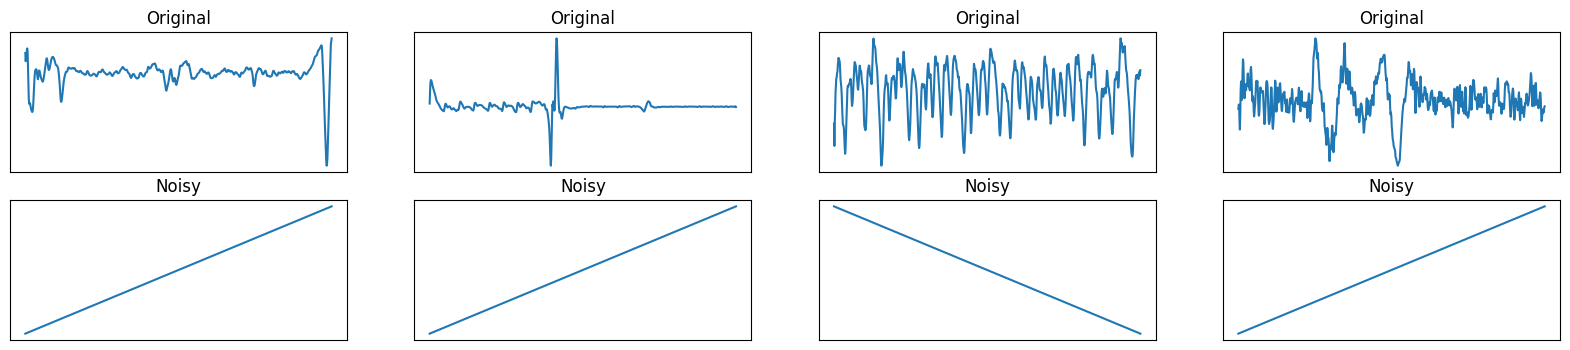

In [18]:
rhythm_predictions = rhythm_branch.predict(test_data)
display(test_data, rhythm_predictions)

In [34]:
predicted_rhythm_labels = np.argmax(rhythm_predictions, axis=1)

predicted_rhythm_labels_one_hot = np.eye(2)[predicted_rhythm_labels]

print("Predicted Rhythm labels:")
print(predicted_rhythm_labels_one_hot[:5])

print("True Rhythm labels:")
print(test_labels_rhythm[:5])

Predicted Rhythm labels:
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
True Rhythm labels:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### QA

In [19]:
# Initial learning rate
initial_lr = 0.01

lr_reduction = LearningRateScheduler(lr_schedule, verbose=1)

# Train Autoencoder
qa_history = qa_branch.fit(
    x=train_data,
    y = train_labels_qa,
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_data, validate_labels_qa),
    callbacks=[lr_reduction]
)

print(qa_history.history) 


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1233 - val_loss: 0.3060 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0850 - val_loss: 0.3021 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0820 - val_loss: 0.3006 - learning_rate: 0.0010
{'loss': [0.10072310268878937, 0.08328653872013092, 0.08079519122838974], 'val_loss': [0.30598270893096924, 0.3021334707736969, 0.3005982041358948], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


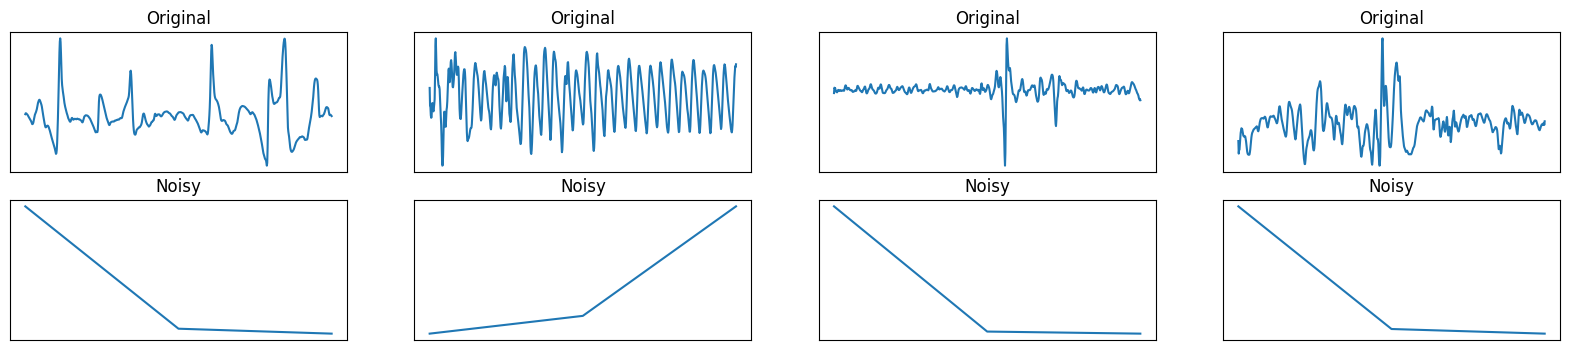

In [ ]:
qa_predictions = qa_branch.predict(test_data)
display(test_data, qa_predictions)

In [35]:
predicted_qa_labels = np.argmax(qa_predictions, axis=1)

predicted_qa_labels_one_hot = np.eye(3)[predicted_qa_labels]

print("Predicted QA labels:")
print(predicted_qa_labels_one_hot[:5])

print("True QA labels:")
print(test_labels_qa[:5])

Predicted QA labels:
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
True QA labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


# Evaluation

In [36]:
# TODO